In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import os, glob
from natsort import natsorted
from tensorflow.keras.preprocessing.image import load_img
import cv2
from tensorflow.keras.utils import image_dataset_from_directory
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Load data into generator

In [148]:
data_dir = '../data/train'
data_dir = pathlib.Path(data_dir)

data_val_dir = '../data/val'
data_val_dir = pathlib.Path(data_val_dir)

data_test_dir = '../data/test'
data_test_dir = pathlib.Path(data_test_dir)

### Load labels

In [149]:
df_labels = pd.read_csv('../data/labels.txt', header = None, names = ['id', 'class', 'x', 'y', 'w', 'h'])
df_val_labels = pd.read_csv('../data/val_labels.txt', header = None, names = ['id', 'class', 'x', 'y', 'w', 'h'])
df_test_labels = pd.read_csv('../data/test_labels.txt', header = None, names = ['id', 'class', 'x', 'y', 'w', 'h'])

In [150]:
def generate_class_list(df):
    class_labels_list = df[['class']].values.tolist()

    y_list = []
    for x in class_labels_list:
        y_list.append(x[0])
        
    return y_list

In [151]:
def generate_bbox_list(df):
    return df[['x', 'y', 'w', 'h']].values.tolist()

In [152]:
y_list = generate_bbox_list(df_labels)
y_val_list = generate_bbox_list(df_val_labels)
y_test_list = generate_bbox_list(df_test_labels)
    
print('First 10 labels: ', y_list[0:10])
print('Number of labels: ', len(y_list))

First 10 labels:  [[0, 0, 62, 62], [46, 5, 8, 8], [31, 7, 16, 16], [29, 9, 10, 10], [2, 2, 52, 52], [18, 23, 38, 38], [4, 3, 58, 58], [26, 18, 24, 24], [9, 11, 28, 28], [17, 19, 42, 42]]
Number of labels:  2000


### Load images into generator

In [153]:
batch_size = 32
img_height = 64
img_width = 64

labels = y_list
val_labels = y_val_list

label_mode = 'int'
shuffle = True

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels = labels,
    label_mode = label_mode,
    color_mode = 'grayscale',
    shuffle = shuffle,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_val_dir,
    labels = val_labels,
    label_mode = label_mode,
    color_mode = 'grayscale',
    shuffle = shuffle,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2000 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


### Load test data

### Visualize the data 

In [155]:
for images, labels in train_ds.take(1):
    print(labels[0:5])

tf.Tensor(
[[25  4 14 42]
 [25 15 34  1]
 [48 58  5  4]
 [11 59  9  3]
 [ 7 44 40  3]], shape=(5, 4), dtype=int32)


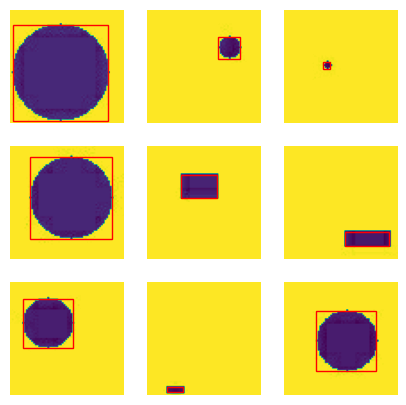

In [156]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        rect = patches.Rectangle((labels[i][0], labels[i][1]), labels[i][2], labels[i][3], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.axis("off")

In [157]:
for image_batch, labels_batch in train_ds:
    print('Image batch shape: ', image_batch.shape)
    print('Labels batch shape: ', labels_batch.shape)
    break

Image batch shape:  (32, 64, 64, 1)
Labels batch shape:  (32, 4)


### Buffer prefetching

In [158]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model definition and training

#### helpers

In [159]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    
def plotTrainingHistory(model):

    fig, axes= plt.subplots(1,1,figsize=(5,5))
    history = model.history
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
def calculate_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x3, y3, w2, h2 = box2
    
    x2, y2 = x1 + w1, y1 + h1
    x4, y4 = x1 + w1, y1 + h1
    
    x_inter1 = max(x1, x3)
    y_inter1 = max(y1, y3)
    x_inter2 = min(x2, x4)
    y_inter2 = min(y2, y4)
    width_inter = abs(x_inter2 - x_inter1)
    height_inter = abs(y_inter2 - y_inter1)
    area_inter = width_inter * height_inter
    width_box1 = abs(x2 - x1)
    height_box1 = abs(y2 - y1)
    width_box2 = abs(x4 - x3)
    height_box2 = abs(y4 - y3)
    area_box1 = width_box1 * height_box1
    area_box2 = width_box2 * height_box2
    area_union = area_box1 + area_box2 - area_inter
    iou = area_inter / area_union
    if iou > 1:
        iou = 0
    return iou

### class-defined model

In [160]:
def CNN_class(nFilters, kernel_size, pool_size, nNeurons, inputShape, outputWidth):
    inputs = tf.keras.Input(shape=inputShape)
    x = inputs
    x = tf.keras.layers.Rescaling(1./255, input_shape=inputShape)(x)
    x = tf.keras.layers.Conv2D(nFilters, kernel_size=kernel_size)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(x)
    x = tf.keras.layers.Conv2D(nFilters, kernel_size=kernel_size)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(nNeurons, activation=tf.nn.relu)(x)
    x = tf.keras.layers.Dense(int(nNeurons / 2), activation=tf.nn.relu)(x)
    x = tf.keras.layers.Dense(int(nNeurons / 2), activation=tf.nn.relu)(x)
    outputs = tf.keras.layers.Dense(outputWidth)(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss = tf.keras.losses.mse, optimizer = 'adam')
    return model

### model training

In [182]:
%%time 

batch_size = 32
nFilters = 32
kernel_size = 3
pool_size = (3,3)
nNeurons = 128 
nHiddenLayers = 1 
inputShape = (64, 64, 1)
outputWidth = 4

epochs = 50

model = CNN_class(nFilters, kernel_size, pool_size, nNeurons, inputShape, outputWidth)
model.summary()
model_fit = model.fit(train_ds, validation_data = val_ds, epochs=epochs) 

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 64, 64, 1)         0         
                                                                 
 conv2d_12 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 20, 20, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 18, 18, 32)        9248      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 6, 6, 32)         0         
 g2D)                                                      

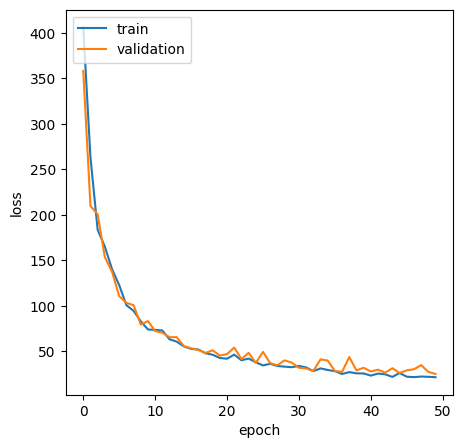

In [183]:
plotTrainingHistory(model_fit)

### testing on test dataset

In [184]:
import glob

test = glob.glob('../data/test/*/*')

In [185]:
def test_predict(data_dir):
    predictions = []
    for path in data_dir:
        img = tf.keras.utils.load_img(path, color_mode='grayscale')
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch
        y = model.predict(img_array, verbose = 0)
        predictions.append(y)
                  
    return predictions

In [186]:
y_pred = test_predict(test)

In [187]:
iou = []
for i in range(len(y_test_list)):
    iou.append(calculate_iou(y_test_list[i], y_pred[i][0]))

In [188]:
print('Mean IoU: ', np.round(np.mean(iou), 2))
print('Mean IoU without 0s: ', np.round(np.mean([i for i in iou if i != 0]), 2))

Mean IoU:  0.73
Mean IoU without 0s:  0.74


4 11 50 50
2.83309 11.326844 50.1548 47.12889


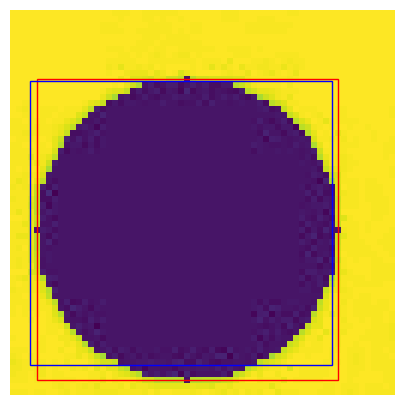

In [191]:
n = 120

x1, y1, wt, ht = y_test_list[n]
x2, y2, wp, hp = y_pred[n][0]
print(x1, y1, wt, ht)
print(x2, y2, wp, hp)

fig = plt.figure(figsize = (5,5))
img = tf.keras.utils.load_img(test[n], color_mode='grayscale')
img_array = tf.keras.utils.img_to_array(img)
plt.imshow(img_array.astype("uint8"))
rect_true = patches.Rectangle((x1, y1), wt, ht, linewidth=1, edgecolor='r', facecolor='none')
rect_pred = patches.Rectangle((x2, y2), wp, hp, linewidth=1, edgecolor='b', facecolor='none')
plt.gca().add_patch(rect_true)
plt.gca().add_patch(rect_pred)
plt.axis("off")
plt.show()